In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Question 1 - Quantization

### Setup

In [2]:
# load lena

lena_im = Image.open('data/lena_gray.bmp')
lena_arr = np.array(lena_im)
lena_vec = lena_arr.flatten()
lena_hist = np.unique(lena_arr, return_counts=True)

In [3]:
# setup histogram 

P = np.zeros(2**8)
P[lena_hist[0]] = lena_hist[1]/lena_arr.size
gray_levels = np.arange(0, 2**8, 1)

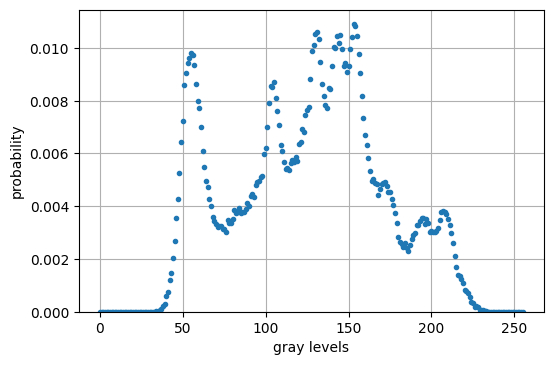

In [4]:
plt.figure(dpi=100)
plt.plot(gray_levels, P, '.')
plt.xlabel('gray levels')
plt.ylabel('probability')
plt.ylim(bottom=0)
plt.grid()
plt.savefig('plots/lena_dist.png')
plt.show()

### Quantization functions and misc.

In [5]:
"""
a function implementing uniform quantization
"""
def uniform_quantization(domain, N):
    decision_levels = np.arange(0,N,1)
    r = np.append(domain[decision_levels * len(domain) // N], domain[-1]+1)
    q = (r[:-1] + r[1:]) / 2
    if domain.dtype == int:
        q = np.floor(q).astype(domain.dtype)
    return r, q

In [6]:
"""
a function implementing the Max-Lloyd algorithm for discrete distributions.
"""
def max_lloyd_quantization(hist, r0, eps=0.5):
    def mse(domain, P, q, r):
        err = 0
        for i in range(len(r)-1):
            interval = (domain >= r[i]) & (domain < r[i+1])
            err += np.sum(((q[i]-domain)**2 * P)[interval])
        
        return err
    
    def step(domain, P, q, r):
        # get q from prev r
        for i in range(len(r)-1):
            interval = (domain >= r[i]) & (domain < r[i+1])
            q[i] = np.sum((domain*P)[interval])/np.sum(P[interval])
        
        # get new r from q
        for i in range(len(q)-1):
            r[i+1] = (q[i] + q[i+1]) / 2

    domain = np.array(hist[0])
    P = np.array(hist[1])
    L = np.min(domain)
    H = np.max(domain)

    if not np.all(r0[:-1] <= r0[1:]):
        raise ValueError("r0 is not sorted.")

    if r0[0] != L or r0[-1] != H+1:
        raise ValueError("first and last values of r0 must be the lowest and highest values in the domain of the histogram.")

    # intervals with 0 probability are problematic, so we perturb the pdf by a small amount
    num_perturb = np.sum(P==0)
    perturbation = np.min(P[P!=0])*1e-3/num_perturb
    P[P==0] = perturbation
    P /= np.sum(P)

    q = np.zeros(len(r0)-1)
    r = np.array(r0, dtype=float)
    
    step(domain, P, q, r)
    err_prev = mse(domain, P, q, r)
    step(domain, P, q, r)
    err = mse(domain, P, q, r)
    while np.abs(err_prev - err) > eps:
        err_prev = err
        step(domain, P, q, r)
        err = mse(domain, P, q, r)

    return r, q

In [7]:
def MSE(x, Qx, P):
    return np.sum((x - Qx)**2*P)

In [8]:
def quantize_data(r, q, data):
    qdata = np.zeros(len(data), dtype=q.dtype)
    for i in range(len(r)-1):
        interval = (data >= r[i]) & (data < r[i+1])
        qdata[interval] = q[i]

    return qdata

In [9]:
def plot_fig_quantization(x, r, q, P):
    fig, ax1 = plt.subplots(dpi=100)
    plt.plot(x, x, label='identity')
    plt.vlines(r,ymin=np.min(x),ymax=np.max(x), linestyles='dashed', colors='darkorange', label='decision levels')
    legend=True
    for i in range(len(r)-1):
        interval = (x >= r[i]) & (x < r[i+1])
        interval_len = np.sum(interval)
        if legend:
            plt.plot(x[interval], np.ones(interval_len)*q[i], label='representation levels', color='darkgreen')
            legend = False
        else:
            plt.plot(x[interval], np.ones(interval_len)*q[i], color='darkgreen')
    plt.ylim((np.min(x), np.max(x)))
    plt.xlim((np.min(x), np.max(x)))
    plt.xlabel('original values')
    plt.ylabel('identity and quantized values')

    ax2 = ax1.twinx()
    ax2.plot(x, P, alpha=0.3, label='pdf', color='black')
    ax2.set_ylabel('probability')

    fig.tight_layout()
    plt.grid()
    ax1.legend(bbox_to_anchor=(1.02,1.28))

    return fig, [ax1, ax2]
    

In [10]:
def plot_b_quantization(b):
    r, q = uniform_quantization(gray_levels, N=2**b)
    lena_vec_q = quantize_data(r, q, lena_vec)
    fig, axs = plot_fig_quantization(x=gray_levels, r=r, q=q, P=P)
    plt.figure(fig)
    axs[0].set_xlabel('gray level')
    # plt.xlabel('gray level')
    plt.savefig(f'plots/quntization_b_{b}.png', bbox_inches='tight')
    plt.show()
    
    lena_arr_q = lena_vec_q.reshape(512,512)
    plt.imshow(lena_arr_q, cmap='gray')
    plt.show()

    lena_img_q = Image.fromarray(lena_arr_q.astype('uint8'), mode='L')
    lena_img_q.save(f'images/lena_uniform_b_{b}.bmp')

### plots

In [11]:
# compute mse from uniform quantization

b_range = np.arange(1,9,1)
uniform_mse = np.zeros(8)
for b in b_range:
    r, q = uniform_quantization(domain=gray_levels, N=2**b)
    gray_levels_q = quantize_data(r, q, gray_levels)
    uniform_mse[b-1] = MSE(x=gray_levels, Qx=gray_levels_q, P=P)

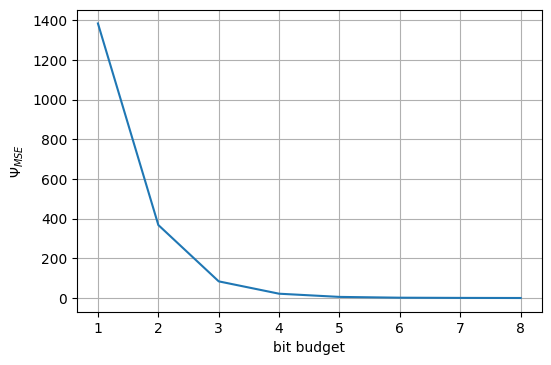

In [12]:
plt.figure(dpi=100)
plt.plot(b_range, uniform_mse, '-')
plt.xlabel('bit budget')
plt.ylabel(r'$\Psi_{MSE}$')
plt.grid()
plt.savefig('plots/MSE_b.png')
plt.show()

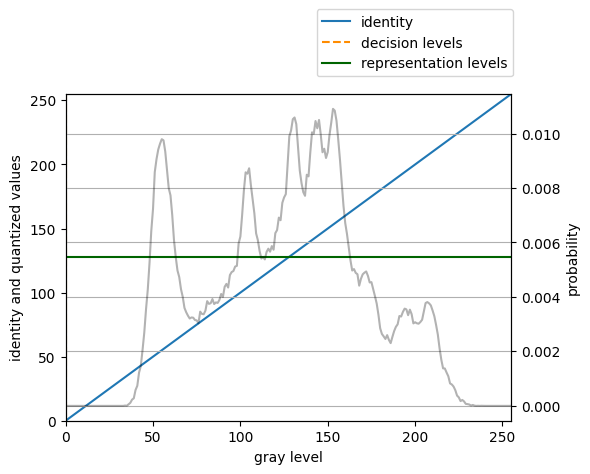

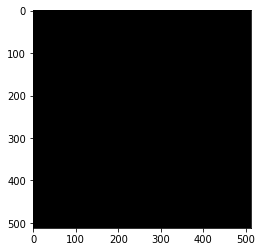

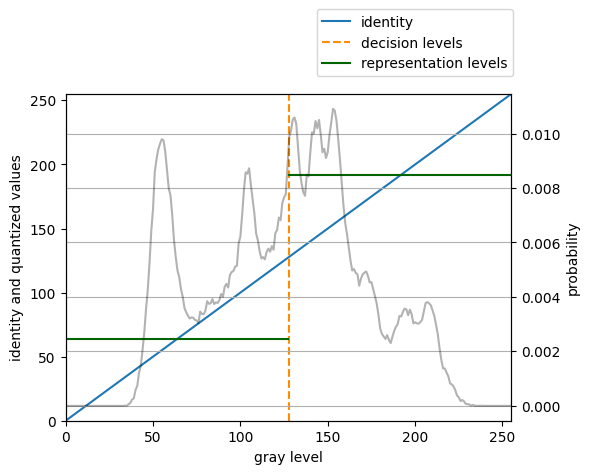

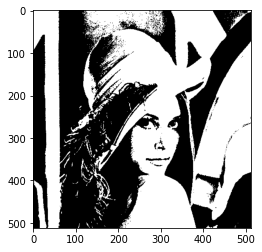

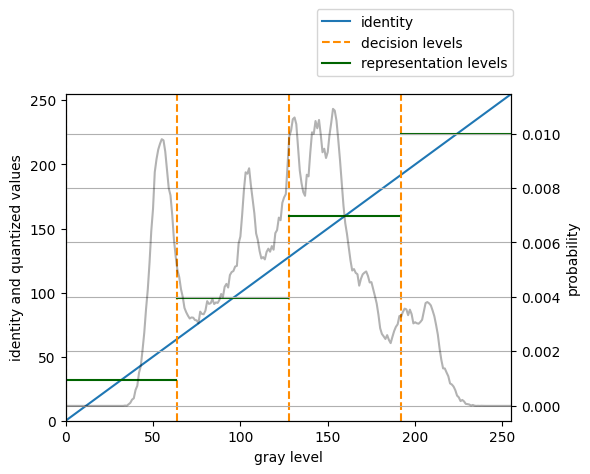

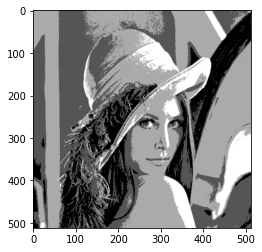

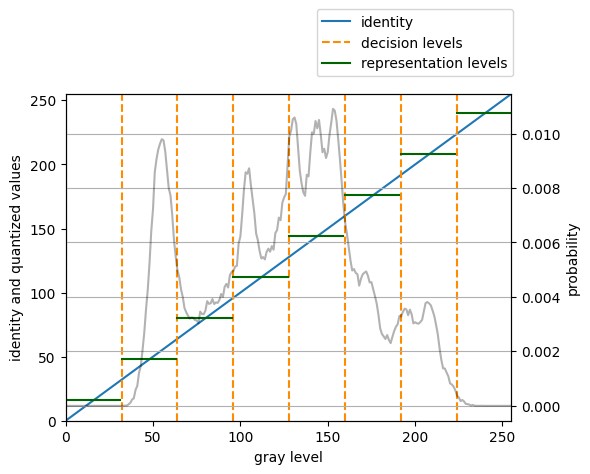

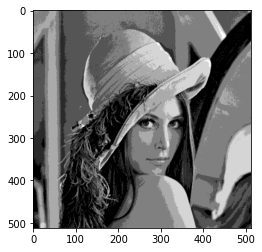

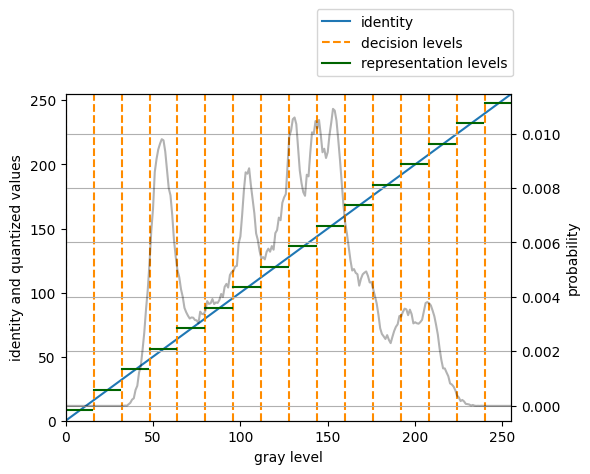

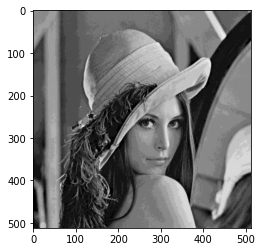

In [13]:
plot_b_quantization(b=0)
plot_b_quantization(b=1)
plot_b_quantization(b=2)
plot_b_quantization(b=3)
plot_b_quantization(b=4)

In [14]:
# compute mse from max-lloyd quantization

max_lloyd_mse = np.zeros(8)
for b in range(1,9):
    delta = 2**(8-b)
    deltas = np.arange(0, 2**8+1, delta)
    r, q = max_lloyd_quantization([gray_levels, P], deltas, eps=1e-3)
    gray_levels_q = quantize_data(r, q, gray_levels)
    max_lloyd_mse[b-1] = MSE(gray_levels, gray_levels_q, P)

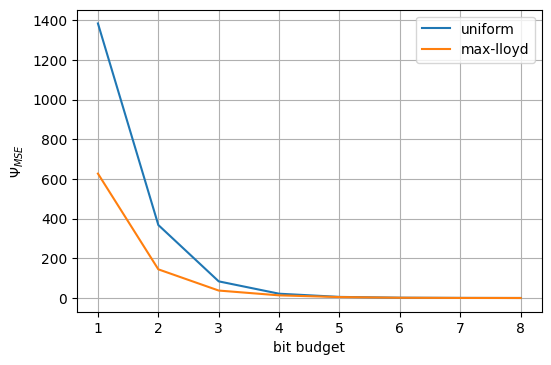

In [15]:
plt.figure(dpi=100)
plt.plot(b_range, uniform_mse, '-', label='uniform')
plt.plot(b_range, max_lloyd_mse, '-', label='max-lloyd')
plt.xlabel('bit budget')
plt.ylabel(r'$\Psi_{MSE}$')
plt.legend()
plt.grid()
plt.savefig('plots/MSE_max_lloyd.png')
plt.show()


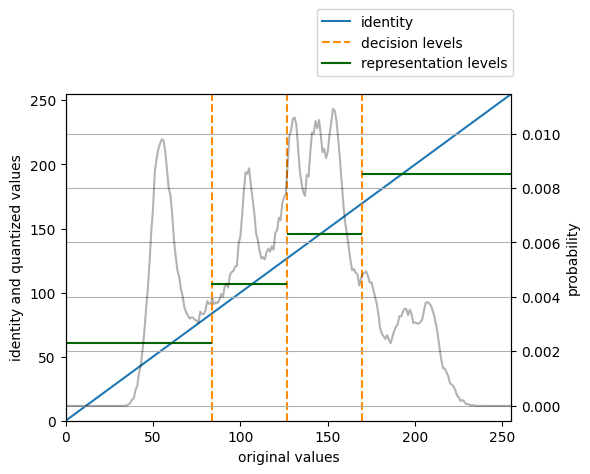

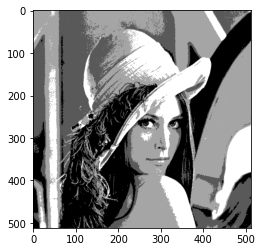

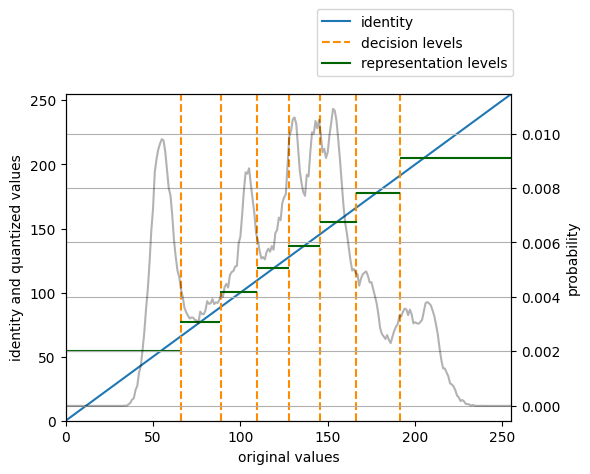

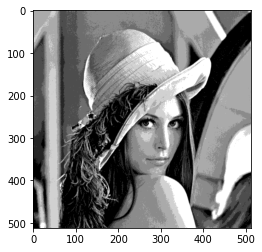

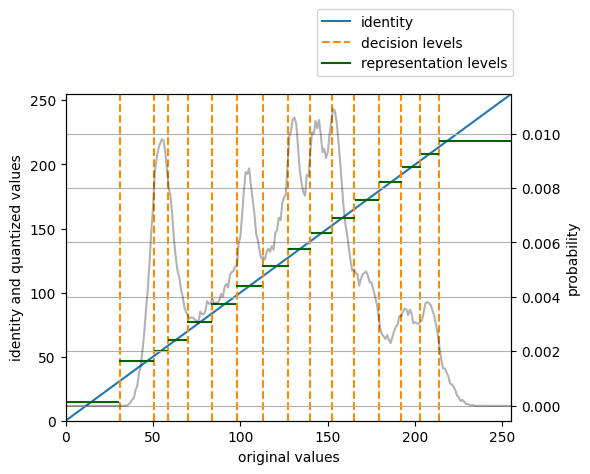

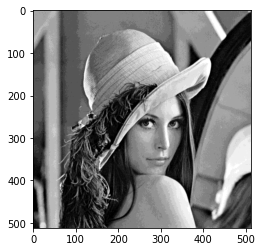

In [16]:
for b in [2,3,4]:
    delta = 2**(8-b)
    deltas = np.arange(0, 2**8+1, delta)
    r, q = max_lloyd_quantization([gray_levels, P], deltas, eps=1e-3)
    fig, axes = plot_fig_quantization(gray_levels, r, q, P)
    plt.figure(fig)
    plt.savefig(f'plots/quantized_lena_max_lloyd_b_{b}.png', bbox_inches='tight')
    plt.show()

    lena_vec_q = quantize_data(r, q, lena_vec)
    
    lena_arr_q = lena_vec_q.reshape(512,512)
    plt.imshow(lena_arr_q, cmap='gray')
    plt.show()

    lena_img_q = Image.fromarray(lena_arr_q.astype('uint8'), mode='L')
    lena_img_q.save(f'images/lena_max_lloyd_b_{b}.bmp')
    